In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import lightkurve

from astropy.table import Table, join, Column
% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [70]:
stars = Table.read('../data/output_1000stars.txt',format='ascii')
kics = ['%09d' %  kic for kic in stars['ID']]

### Download data


In [72]:
preamble = "wget -q -nH --cut-dirs=6 -r -l0 -c -N -np -R 'index*' -erobots=off " 

with open('../data/download_kics.txt','w') as f:
    for kic in kics:
        url = "http://archive.stsci.edu/pub/kepler/lightcurves/%s/%s/" %  (kic[:4], kic)
        f.write(preamble+url+'\n')


### Can we cut it into chunks?

In [193]:
def get_chunks(lc,duration=48*2):
    ffs, tts = [],[]
    flat = lc.remove_outliers(sigma=2.5).flatten()
    flat.fill_gaps()
    
    time, flux = flat.time, flat.flux
    flux /= np.nanmedian(flux)
    t0 = np.nanmin(time)

    for day in range(len(time) // duration):
        tts.append(time[day*duration:(day+1)*duration])
        ffs.append(flux[day*duration:(day+1)*duration])
        
    return tts, ffs 

In [194]:
fnames = glob.glob('../data/*%s*.fits' % '010651320')
lc = lightkurve.open(fnames[9]).PDCSAP_FLUX
tts, ffs = get_chunks(lc)

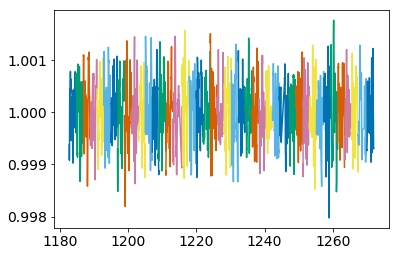

In [195]:
for j, ff in enumerate(ffs):
    plt.plot(tts[j],ff)

### Chunk everything

In [196]:
%%time
fnames = glob.glob('../data/*.fits')

ffs_all = []

for j, fname in enumerate(fnames):
    if j % 25 ==  0:
        print(j,fname)
    lc = lightkurve.open(fname).PDCSAP_FLUX
    tts, ffs = get_chunks(lc)
    
    ffs_all.extend(ffs)
    
print('Finished!')

0 ../data/kplr011231549-2011177032512_llc.fits
25 ../data/kplr005599763-2010078095331_llc.fits
50 ../data/kplr011394905-2013131215648_llc.fits
75 ../data/kplr010910802-2012179063303_llc.fits
100 ../data/kplr011767058-2012277125453_llc.fits
125 ../data/kplr007020371-2010174085026_llc.fits
150 ../data/kplr011559478-2012179063303_llc.fits
175 ../data/kplr009077844-2009259160929_llc.fits
200 ../data/kplr005285357-2010078095331_llc.fits
225 ../data/kplr004164910-2013011073258_llc.fits
250 ../data/kplr009469165-2012277125453_llc.fits
275 ../data/kplr009205705-2012277125453_llc.fits
300 ../data/kplr008824264-2011073133259_llc.fits
325 ../data/kplr010525282-2011177032512_llc.fits
350 ../data/kplr004570120-2011177032512_llc.fits
375 ../data/kplr006428974-2009166043257_llc.fits
400 ../data/kplr010199187-2012088054726_llc.fits
425 ../data/kplr009269772-2012088054726_llc.fits
450 ../data/kplr011453627-2010355172524_llc.fits
475 ../data/kplr008545504-2011271113734_llc.fits
500 ../data/kplr007025721

In [197]:
array = np.array(ffs_all).T

In [198]:
nchunks = 2**15
print('Taking %d chunks' % nchunks)
indices = np.random.choice(np.arange(array.shape[1]),nchunks)

subsampled = array[:,indices[:nchunks/2]]
validation = array[:,indices[nchunks/2:]]
np.savetxt('subsampled.csv',minmax_scale(subsampled,axis=0)*2.-1.)
np.savetxt('subsampled.csv',minmax_scale(subsampled,axis=0)*2.-1.)

Taking 16384 chunks
